In [1]:
# Slidin' Videos: Use high-precision text tracking and semantic segmentation for chapters generation

#### Please register for the Slidin' Videos challenge to get download URLs used in this notebook 

## 1. Deeplab finetuning
#### DeepLabV3 model is a pretrained model for semantic segmentation of images. We will finetune it on Slidin' Videos dataset of slide titles

!git clone https://github.com/msminhas93/DeepLabv3FineTuning.git
!pip install -q torch torchvision pandas scikit-learn
!pip install -q opencv-python-headless Shapely Pillow easyocr


Cloning into 'DeepLabv3FineTuning'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 352 (delta 3), reused 9 (delta 3), pack-reused 340
Receiving objects: 100% (352/352), 4.09 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
# !pip install -q Pillow==6.2.2

In [3]:
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
#comment or skip if in colab
!cp /kaggle/input/notebookb7b076d71e/* /kaggle/working/

In [5]:
!ls

DeepLabv3FineTuning		    Train.csv		       __output__.json
SampleSubmission.csv		    Train.zip		       __results__.html
SlidinVideos_StarterNotebook.ipynb  __notebook__.ipynb	       custom.css
Test.zip			    __notebook_source__.ipynb


In [6]:
#### Download title masks collection and unzip it to the cloned repository. 

!unzip -q Train.zip -d DeepLabv3FineTuning/

In [7]:
!ls DeepLabv3FineTuning

Analysis.ipynb	README.md		       model.py
CFExp		SegmentationDatasetDemo.ipynb  requirements.txt
CrackForest	Tests			       segdataset.py
Images		datahandler.py		       trainer.py
LICENSE.md	environment.yml
Masks		main.py


In [8]:
!mkdir DeepLabv3FineTuning/Train

In [9]:
!mv DeepLabv3FineTuning/Images DeepLabv3FineTuning/Train
!mv DeepLabv3FineTuning/Masks DeepLabv3FineTuning/Train

In [10]:
#### Training DeepLab model: our goal is to maximize test_f1_score
#### You may want to play with number of epochs, learning rate and loss function to get better results

%cd DeepLabv3FineTuning
from pathlib import Path

#from segmentation_models_pytorch.losses.jaccard  import JaccardLoss
#from segmentation_models_pytorch.losses.constants import BINARY_MODE
#criterion = JaccardLoss(mode=BINARY_MODE)

import torch
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils import data

import datahandler
from model import createDeepLabv3
from trainer import train_model

/kaggle/working/DeepLabv3FineTuning


In [11]:
# Create the deeplabv3 resnet101 model which is pretrained on a subset
# of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
model = createDeepLabv3()
model.train()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:03<00:00, 67.0MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
data_directory = Path("Train")
# Create the experiment directory if not present
exp_directory = Path("DemoExp")
if not exp_directory.exists():
    exp_directory.mkdir()

epochs = 10

# Specify the evaluation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

# Create the dataloader
dataloaders = datahandler.get_dataloader_single_folder(
    data_directory, fraction=0.2, image_folder="Images", 
    mask_folder="Masks", batch_size=4)



# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')

# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
_ = train_model(model, 
                criterion,
                dataloaders,
                optimizer,
                bpath=exp_directory,
                metrics=metrics,
                num_epochs=epochs)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/10
----------


100%|██████████| 427/427 [22:43<00:00,  3.19s/it]


Train Loss: 0.0071


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:32<00:00,  1.42s/it]

Test Loss: 0.0080
{'epoch': 1, 'Train_loss': 0.00710871908813715, 'Test_loss': 0.008043285459280014, 'Train_f1_score': 0.5353042966692378, 'Train_auroc': 0.9671830781113694, 'Test_f1_score': 0.6396798334509854, 'Test_auroc': 0.9831193741013725}
Epoch 2/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:21<00:00,  3.14s/it]


Train Loss: 0.0034


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:30<00:00,  1.40s/it]

Test Loss: 0.0039
{'epoch': 2, 'Train_loss': 0.0033545151818543673, 'Test_loss': 0.003944626543670893, 'Train_f1_score': 0.7256146175430891, 'Train_auroc': 0.9885344372783877, 'Test_f1_score': 0.7107763022551231, 'Test_auroc': 0.9771864531624973}
Epoch 3/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:20<00:00,  3.14s/it]


Train Loss: 0.0087


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:30<00:00,  1.41s/it]

Test Loss: 0.0119
{'epoch': 3, 'Train_loss': 0.008653498254716396, 'Test_loss': 0.01191536895930767, 'Train_f1_score': 0.7717763250461654, 'Train_auroc': 0.9912208096313366, 'Test_f1_score': 0.7716626601818719, 'Test_auroc': 0.9785666561337081}
Epoch 4/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:23<00:00,  3.15s/it]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

Train Loss: 0.0046


100%|██████████| 107/107 [02:29<00:00,  1.40s/it]

Test Loss: 0.0108
{'epoch': 4, 'Train_loss': 0.004634416662156582, 'Test_loss': 0.010798330418765545, 'Train_f1_score': 0.7934208497824026, 'Train_auroc': 0.9912161292265715, 'Test_f1_score': 0.734653482039265, 'Test_auroc': 0.9807433576996049}
Epoch 5/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:21<00:00,  3.14s/it]


Train Loss: 0.0106


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:29<00:00,  1.40s/it]

Test Loss: 0.0028
{'epoch': 5, 'Train_loss': 0.010614058002829552, 'Test_loss': 0.002827313030138612, 'Train_f1_score': 0.8078147822679734, 'Train_auroc': 0.9923980791827444, 'Test_f1_score': 0.7805921021577369, 'Test_auroc': 0.9747480259486644}
Epoch 6/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:21<00:00,  3.14s/it]


Train Loss: 0.0121


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:29<00:00,  1.40s/it]

Test Loss: 0.0062
{'epoch': 6, 'Train_loss': 0.012102605774998665, 'Test_loss': 0.006158528383821249, 'Train_f1_score': 0.8273111265844283, 'Train_auroc': 0.9934650600099271, 'Test_f1_score': 0.7133696736915995, 'Test_auroc': 0.9776662100198129}
Epoch 7/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:21<00:00,  3.14s/it]


Train Loss: 0.0032


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:28<00:00,  1.39s/it]

Test Loss: 0.0025
{'epoch': 7, 'Train_loss': 0.00316074350848794, 'Test_loss': 0.002516398439183831, 'Train_f1_score': 0.8192699152199758, 'Train_auroc': 0.9930732946388067, 'Test_f1_score': 0.7619397575631555, 'Test_auroc': 0.9763785836425938}
Epoch 8/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:21<00:00,  3.14s/it]


Train Loss: 0.0033


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:28<00:00,  1.39s/it]

Test Loss: 0.0034
{'epoch': 8, 'Train_loss': 0.00332265323959291, 'Test_loss': 0.0034082087222486734, 'Train_f1_score': 0.8246260691790057, 'Train_auroc': 0.9927644843256622, 'Test_f1_score': 0.7794834646249333, 'Test_auroc': 0.9764710067057867}
Epoch 9/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:27<00:00,  3.16s/it]


Train Loss: 0.0038


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:28<00:00,  1.39s/it]

Test Loss: 0.0022
{'epoch': 9, 'Train_loss': 0.003756810910999775, 'Test_loss': 0.0022481081541627645, 'Train_f1_score': 0.8498684924862205, 'Train_auroc': 0.9942073473476624, 'Test_f1_score': 0.7832280206069961, 'Test_auroc': 0.9811393019913267}
Epoch 10/10
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 427/427 [22:22<00:00,  3.14s/it]


Train Loss: 0.0035


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 107/107 [02:28<00:00,  1.39s/it]

Test Loss: 0.0040
{'epoch': 10, 'Train_loss': 0.003494900418445468, 'Test_loss': 0.003988641779869795, 'Train_f1_score': 0.849211692876195, 'Train_auroc': 0.9947477913463709, 'Test_f1_score': 0.6515920435807648, 'Test_auroc': 0.9742369456592747}
Training complete in 249m 27s
Lowest Loss: 0.002248


In [13]:

# Save the trained model
torch.save(model, exp_directory / 'weights.pt')

# Terminate
exit()
%cd ../


/kaggle/working


In [14]:
## 2. Making the submission
#### Unpack the testset
!unzip -q Test.zip

In [1]:
!ls

DeepLabv3FineTuning		    Train.zip
Images				    __notebook__.ipynb
SampleSubmission.csv		    __notebook_source__.ipynb
SlidinVideos_StarterNotebook.ipynb  __output__.json
Test.zip			    __results__.html
Train.csv			    custom.css


In [2]:
!mkdir Test
!mv Images/ Test/

In [3]:
#### Load finetuned deeplab model and define helper functions

import glob
import os
import json
import cv2    
import torch
import numpy as np
import pandas as pd

from torchvision import transforms  
from PIL import Image

deeplab_width = 768
deeplab_height = 432
deeplab = torch.load('DeepLabv3FineTuning/DemoExp/weights.pt')
deeplab.eval()
     

def boxify(out, boxes):
    return [ torch.mean(out[b[0]:b[1], b[2]:b[3]]).item()  for b in boxes ]      

def titlesegment(image, boxes):
    # Resize the frame to the training input size
    inputs = transforms.ToTensor()(Image.fromarray(image, mode="RGB"))
    inputs = inputs.reshape(1, *inputs.shape).to('cuda')
    
    with torch.set_grad_enabled(False):
        outputs = deeplab(inputs)
        out = outputs['out'][0][0]
        box_scores = boxify(out, boxes)
        return out, np.array(box_scores)
    
def occupation(boxes):
    area = lambda b: (b[1]-b[0]) * (b[3]-b[2])
    y1, y2 = min([b[0] for b in boxes ]), max([b[1] for b in boxes ])
    x1, x2 = min([b[2] for b in boxes ]), max([b[3] for b in boxes ])
    return 1.0 * sum([ area(b) for b in boxes ]) / area([y1, y2, x1, x2])

# Locates a paragraph of text with the highest probability 
# to be a slide title 
def pickonetitle(boxes, scores):
    if len(boxes) == 0:
        return []
        
    best_idx = np.argmax(scores)
    best = boxes[best_idx]

    candidates = { i for i, box in enumerate(boxes) 
        if abs(box['fontsize']-best['fontsize']) <= best['fontsize'] * 0.25 
            and scores[best_idx] - scores[i] < 0.6 }
    
    while occupation([ boxes[i]['bbox'] for i in candidates ]) < 0.75:
        combinations = [ candidates - {j} for j in candidates if j != best_idx ]
        candidates = max(combinations, 
            key=lambda comb: occupation([ boxes[j]['bbox'] for j in comb ]))
            
    title_boxes = [ boxes[i] for i in candidates ]
    return title_boxes    

#### Now, we're going to use EasyOCR package to "read" the titles. Modern OCR solutions may still produce a handful of errors, which is why you're encouraged to apply a language model or alternative OCR model to fix possible misspelings. 

from shapely.geometry import Polygon, LineString

import easyocr
reader = easyocr.Reader(['en']) 

def sameline(a, b):
    return ((min(a['bbox'][1], b['bbox'][1]) - max(a['bbox'][0], b['bbox'][0]))
            / min(a['height'], b['height'])) >= 0.8
            
def isbelow(a, b):
    return not sameline(a, b) and a['bbox'][0] > b['bbox'][0]  
    
def isright(a, b):
    return sameline(a, b) and a['bbox'][2] > b['bbox'][2]  

def sort_boxes(boxes):              
    boxes_ = []
    for b in boxes:
        i = 0
        while i < len(boxes_) and (isbelow(b, boxes_[i]) or isright(b, boxes_[i])):
            i += 1
        boxes_.insert(i, b)
    return boxes_

def _norm_bbox(bbox):
    return  [ int(max(0, min([ p[1] for p in bbox ]))), 
              int(max([ p[1] for p in bbox ])), 
              int(max(0, min([ p[0] for p in bbox ]))), 
              int(max([ p[0] for p in bbox ])) ]

def process_ocr(ocr_results):
    items = []
    for bbox, text, conf in ocr_results:
        if text == '' or conf <= 0:
            continue  
        if not isinstance(bbox, list):
            bbox = bbox.tolist()
        item = {}
        item['width'] = LineString(bbox[0:2]).length
        item['height'] = LineString(bbox[1:3]).length
        item['area'] = item['width'] * item['height']
        item['fontsize'] = 1.0 * item['width'] / len(text)
        item['bbox'] = _norm_bbox(bbox)            
        item['text'] = text
        item['conf'] = float(conf)
        items.append(item)
    return items     

def read_text(img):
    return process_ocr(reader.readtext(img))

### Data exploration
#### First, we will pick some random test slide and will extract any instance of text on it

from IPython.display import display, JSON, Image as IImage

def draw_boxes(frame, boxes):
    for box in boxes:
        frame = cv2.rectangle(frame, (box[2], box[0]), (box[3], box[1]), (36,255,12), 2)
    return frame

In [4]:
!ls Test/Images/*33.jpg

Test/Images/Id_76dbm25833.jpg


In [5]:
!ls Test/Images/*.jpg | wc -l

290


In [6]:
!ls Test/Images/*.jpg | head -n 5

Test/Images/Id_06cra35n6n.jpg
Test/Images/Id_08bjq60t4q.jpg
Test/Images/Id_0g2lwbt3sa.jpg
Test/Images/Id_0h1arzmj2p.jpg
Test/Images/Id_0khgx7z8tk.jpg
ls: write error: Broken pipe


In [7]:
import re
''.join(re.findall(r'\d+', "Id_0khgx7z8tk.jpg"))

'078'

'Test slide #33'

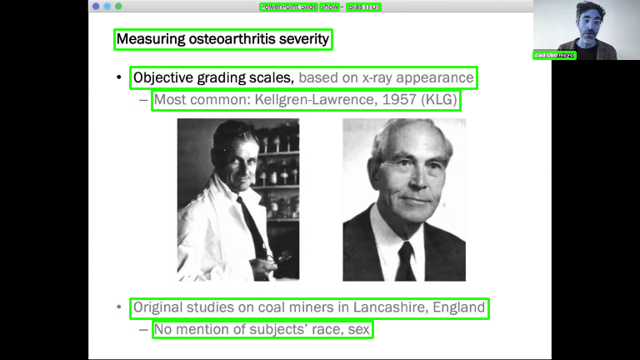

,width,height,area,fontsize,bbox,text
0,68.0,8.0,544.0,4.250000,"[4, 12, 312, 380]",powerpcint Slide
1,22.0,8.0,176.0,4.400000,"[4, 12, 384, 406]",snout
2,40.0,8.0,320.0,4.444444,"[4, 12, 416, 456]",(Bias UUI
3,261.0,24.0,6264.0,7.909091,"[35, 59, 137, 398]",Measuring osteoarthritis severity
4,50.0,8.0,400.0,4.545455,"[62, 70, 640, 690]",Zud Gu4mcyc


In [8]:
# Load some test image and read the text on it
slide_ = cv2.imread('Test/Images/Id_76dbm25833.jpg')

textboxes_ = read_text(slide_)

textdata_ = pd.DataFrame(list(textboxes_))
del textdata_['conf']
             
slide_debug_ = draw_boxes(slide_, [ box['bbox'] for box in textboxes_ ])

display(f"Test slide #33", 
    Image.fromarray(slide_debug_).resize((640,360)), textdata_.head(5))

In [9]:
slide_

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [146, 155, 164],
        [147, 154, 163],
        [146, 153, 162]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [146, 155, 164],
        [147, 154, 163],
        [147, 154, 163]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [150, 157, 166],
        [149, 156, 165],
        [148, 155, 164]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

'Test slide #33 (segmentation output)'

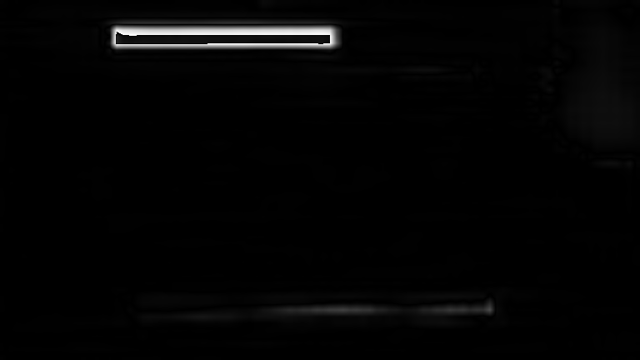

,width,height,area,fontsize,bbox,text,score
0,68.0,8.0,544.0,4.250000,"[4, 12, 312, 380]",powerpcint Slide,0.010634
1,22.0,8.0,176.0,4.400000,"[4, 12, 384, 406]",snout,0.004228
2,40.0,8.0,320.0,4.444444,"[4, 12, 416, 456]",(Bias UUI,0.005721
3,261.0,24.0,6264.0,7.909091,"[35, 59, 137, 398]",Measuring osteoarthritis severity,0.875565
4,50.0,8.0,400.0,4.545455,"[62, 70, 640, 690]",Zud Gu4mcyc,-0.005611


In [10]:
#### Now, we will apply finetuned DeepLab model and "score" each textbox as to whether it might be a title or not

out, scores = titlesegment(slide_, [ box['bbox'] for box in textboxes_ ])
out_mask = (np.abs(out.cpu().numpy())*255).astype(np.uint8)

textdata_['score'] = scores

display(f"Test slide #33 (segmentation output)", Image.fromarray(out_mask).resize((640,360)), textdata_.head(5))


In [12]:
[''.join(re.findall(r'\d+', x)) for x in os.listdir('Test/Images')]

['5',
 '16',
 '52',
 '9',
 '561706',
 '0086',
 '0',
 '189',
 '3679',
 '233',
 '48',
 '8722',
 '7318',
 '4',
 '93',
 '5',
 '',
 '1571',
 '07',
 '33',
 '5',
 '55512',
 '82987',
 '464288',
 '134',
 '85',
 '5975',
 '6423',
 '49',
 '7824',
 '4921',
 '5988',
 '7279',
 '0',
 '6419',
 '93',
 '625',
 '616387',
 '2621',
 '0',
 '60957',
 '44',
 '49',
 '3',
 '078',
 '2682',
 '08',
 '617829',
 '599',
 '184464',
 '',
 '940380',
 '274',
 '4',
 '67',
 '144',
 '85',
 '5952',
 '7999971',
 '58',
 '0',
 '5210',
 '7061',
 '2',
 '30',
 '0',
 '7625833',
 '023',
 '8325',
 '14',
 '7',
 '66',
 '4',
 '5295',
 '35',
 '3',
 '66',
 '633',
 '972',
 '44897',
 '73',
 '019768',
 '31',
 '151',
 '204',
 '774',
 '1744',
 '7',
 '2600',
 '33',
 '20',
 '05',
 '97369',
 '0616',
 '506',
 '8',
 '07',
 '795',
 '70',
 '43',
 '12',
 '635808',
 '34',
 '99',
 '721',
 '7760',
 '503',
 '6',
 '0752',
 '42',
 '133',
 '6',
 '242',
 '538591',
 '046',
 '475999',
 '3',
 '61',
 '3',
 '4',
 '08604',
 '7',
 '42',
 '62',
 '858812',
 '633',
 '98

In [17]:
#### Iterate this method on all test images
from tqdm import tqdm

images = sorted(glob.glob('Test/Images/*.jpg'))
result = []

for path in tqdm(images):
    image = cv2.imread(path)
    textboxes = read_text(image)

    out, scores = titlesegment(image, [ box['bbox'] for box in textboxes ])
    titleboxes = pickonetitle(textboxes, scores)
    
    # Sort text boxes as you would read it in English: from top to bottom
    # and from left to right
    titleboxes = sort_boxes(titleboxes)
    title = ' '.join(box['text'] for box in titleboxes)    
    
    image_id = path.split("/")[-1] #int(''.join(re.findall(r'\d+', path.split('.')[0].split('/')[-1])))
    result.append([image_id, title])


#### Convert the result to a dataframe and save it

df = pd.DataFrame.from_records(result, columns=['ID','Title'])
df


100%|██████████| 290/290 [02:29<00:00,  1.94it/s]


,ID,Title
0,Id_06cra35n6n.jpg,Detect potential security threats
1,Id_08bjq60t4q.jpg,Alina Barnett
2,Id_0g2lwbt3sa.jpg,Part 2: Convection DL instabilities & spurious...
3,Id_0h1arzmj2p.jpg,"Take any ""standard"" black box CNN:"
4,Id_0khgx7z8tk.jpg,Predict; prevent and detect insurance fraud
...,...,...
285,Id_zp77iny60p.jpg,Monitor environmental changes and measure ener...
286,Id_zrs2rtf33n.jpg,The Safe System Pillars
287,Id_zvhdc5e9ra.jpg,Stop explaining black box machine learning mod...
288,Id_zvhpkbv4rk.jpg,Interactive Machines


In [18]:
df.to_csv('Submission.csv', index=False)